# GPJax Regression tutorial

In [1]:
import jax
from jax import config

config.update("jax_enable_x64", True)

from jax import jit
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import install_import_hook
import matplotlib as mpl
import matplotlib.pyplot as plt
import optax as ox

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx

key = jr.PRNGKey(123)
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

/opt/anaconda3/envs/project_wp289/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [2]:
n = 100
noise = 0.3

key, subkey = jr.split(key)
x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(subkey, shape=signal.shape) * noise

D = gpx.Dataset(X=x, y=y)

xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(xtest)


In [3]:
def clean_legend(ax):
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    return ax

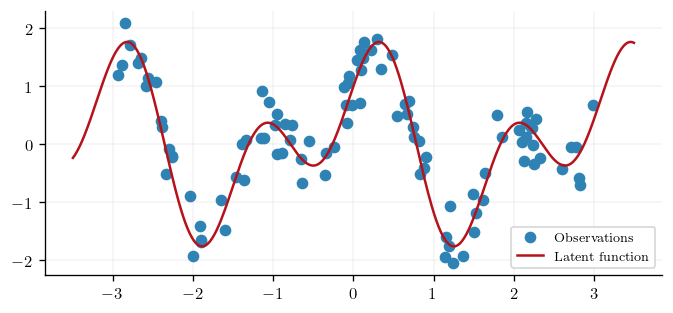

In [4]:
fig, ax = plt.subplots()
ax.plot(x, y, "o", label="Observations", color=cols[0])
ax.plot(xtest, ytest, label="Latent function", color=cols[1])
ax.legend(loc="best")
plt.show()

In [5]:
from dataclasses import dataclass, field

from beartype.typing import Union
import jax.numpy as jnp
from jaxtyping import Float
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd

from gpjax.base import param_field
from gpjax.kernels.base import AbstractKernel
from gpjax.kernels.stationary.utils import squared_distance
from gpjax.typing import (
    Array,
    ScalarFloat,
)

# Define a bijector that maps [0, inf) to [0.5, 3.5]
def create_interval_bijector(lower=0.5, upper=3.5):
    range_width = upper - lower
    return tfb.Chain([
        tfb.Shift(lower),  # Shifts the output of Softplus by lower bound
        tfb.Scale(range_width / tfb.Softplus().forward(jnp.array(1.0)))  # Scale to the range width
    ])

interval_bijector = create_interval_bijector(jnp.array(3.5, dtype=jnp.float64), jnp.array(0.5, dtype=jnp.float64))

@dataclass
class RBF2(AbstractKernel):
    r"""The Radial Basis Function (RBF) kernel."""

    lengthscale: float = field(
        default=1.0, metadata={"bijector": interval_bijector, "trainable": True, "name": "kernel_lengthscale"}
    )
    variance: ScalarFloat = param_field(jnp.array(2.0), bijector=tfb.Softplus(),metadata={"name": "kernel_variance"}, trainable=True)
    name: str = "RBF"

    def __call__(self, x: Float[Array, " D"], y: Float[Array, " D"]) -> ScalarFloat:

        x = self.slice_input(x) / self.lengthscale
        y = self.slice_input(y) / self.lengthscale
        K = self.variance * jnp.exp(-0.5 * squared_distance(x, y))
        return K.squeeze()

In [6]:
kernel = RBF2()
#kernel = kernel.replace_trainable(variance=False)
meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

/opt/anaconda3/envs/project_wp289/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


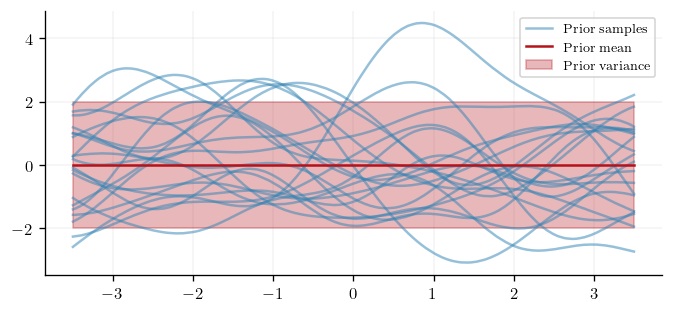

In [7]:
prior_dist = prior.predict(xtest)

prior_mean = prior_dist.mean()
prior_std = prior_dist.variance()
samples = prior_dist.sample(seed=key, sample_shape=(20,))


fig, ax = plt.subplots()
ax.plot(xtest, samples.T, alpha=0.5, color=cols[0], label="Prior samples")
ax.plot(xtest, prior_mean, color=cols[1], label="Prior mean")
ax.fill_between(
    xtest.flatten(),
    prior_mean - prior_std,
    prior_mean + prior_std,
    alpha=0.3,
    color=cols[1],
    label="Prior variance",
)
ax.legend(loc="best")
ax = clean_legend(ax)
plt.show()  

In [8]:
def initialise_gp(kernel, mean, dataset):
    prior = gpx.gps.Prior(mean_function=mean, kernel=kernel)
    likelihood = gpx.likelihoods.Gaussian(
        num_datapoints=dataset.n)
    posterior = prior * likelihood
    return posterior

In [9]:
posterior = initialise_gp(kernel, meanf, D)

In [10]:
def steal_diag_params(diag_params, dataset_coll_train, kernel):
    
    meanf = gpx.mean_functions.Zero()
    art_posterior = initialise_gp(kernel, meanf, dataset_coll_train)
    ravel_func = jax.flatten_util.ravel_pytree(art_posterior)[1]
    
    opt_art_posterior = ravel_func(diag_params)
    
    return opt_art_posterior

In [11]:
def optimise_mll(posterior, dataset, NIters=1000, key=key):
    # define the MLL using dataset_train
    objective = gpx.objectives.ConjugateMLL(negative=True)
    # Optimise to minimise the MLL
    opt_posterior, history = gpx.fit_scipy(
        model=posterior,
        objective=objective,
        train_data=dataset,
    )
    return opt_posterior

In [12]:
opt_posterior = optimise_mll(posterior, D)

Optimization terminated successfully.
         Current function value: 55.103686
         Iterations: 13
         Function evaluations: 18
         Gradient evaluations: 18


In [14]:
rbf_psd = kernel.gram(xtest).to_dense()

def is_pos_def(x):
    return jnp.all(jnp.linalg.eigvals(x) > 0)

print(is_pos_def(rbf_psd))

False


In [58]:
jax.tree_util.tree_flatten(posterior)[0]

[Array(1., dtype=float64, weak_type=True),
 1.0,
 Array(2., dtype=float64, weak_type=True)]

In [59]:
jax.tree_util.tree_flatten(opt_posterior)[0]

[Array(0.31996358, dtype=float64),
 Array(-0.45539487, dtype=float64),
 Array(1.26104245, dtype=float64)]

In [60]:
print(kernel)
print(kernel.unconstrain())
print(kernel.constrain())

RBF2(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=1.0, variance=Array(2., dtype=float64, weak_type=True))
RBF2(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(1.09438474, dtype=float64), variance=Array(1.85458654, dtype=float64))
RBF2(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(1.21561142, dtype=float64), variance=Array(2.12692801, dtype=float64, weak_type=True))


In [61]:
opt_posterior.prior.kernel

RBF2(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(-0.45539487, dtype=float64), variance=Array(1.26104245, dtype=float64))

In [62]:
def create_interval_bijector(lower=0.5, upper=3.5):
    range_width = upper - lower
    softplus_output_at_1 = tfb.Softplus().forward(jnp.array(1.0))
    scale_factor = range_width / (2 * softplus_output_at_1)
    return tfb.Chain([
        tfb.Softplus(),  # Maps the real numbers to the positive real numbers
        tfb.Shift(lower),  # Shifts the output of Softplus by the lower bound
        tfb.Scale(scale_factor)  # Scales the output to the desired range width
    ])

# Create the bijector
my_bijector = create_interval_bijector(lower=jnp.array(0.5, dtype=jnp.float64), upper=jnp.array(3.5, dtype=jnp.float64))

# Define the number to test
x = jnp.array(19.753945393551536, dtype=jnp.float64)

# Apply the bijector to the number
y = my_bijector.forward(x)

# Print the result
print(y)

23.06284362216476


In [63]:
tf = tfb.Chain([tfb.Scale(jnp.array(3.0, dtype=jnp.float64)), tfb.Shift(jnp.array(0.5, dtype=jnp.float64))])

sigmoid_bijector = tfb.Sigmoid()


com2 = tfb.Chain([tfb.Sigmoid(), tfb.Scale(jnp.array(3.0, dtype=jnp.float64)), tfb.Shift(jnp.array(0.5, dtype=jnp.float64))])

com2_rev = tfb.Chain([tfb.Shift(jnp.array(0.5, dtype=jnp.float64)), tfb.Scale(jnp.array(3.0, dtype=jnp.float64)), tfb.Sigmoid()])

l = jnp.array(8, dtype=jnp.float64)
constrained_l = com2.forward(l)
sigmoid_l = sigmoid_bijector.forward(l)
rev_l = com2_rev.forward(l)

print(l)
print(sigmoid_l)
print(sigmoid_l * 3 + 0.5)
print(constrained_l)
print(rev_l)


8.0
0.9996646498695336
3.498993949608601
0.9999999999915765
3.498993949608601


In [64]:
opt_posterior.prior.kernel.constrain()

RBF2(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(4.54029884, dtype=float64), variance=Array(1.51052291, dtype=float64))

In [65]:
params = jnp.array(jax.tree_util.tree_flatten(posterior)[0])

new_params = steal_diag_params(params, D, kernel)

In [66]:
new_params

ConjugatePosterior(prior=Prior(kernel=RBF2(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(1., dtype=float64), variance=Array(2., dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06), likelihood=Gaussian(num_datapoints=100, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(1., dtype=float64)), jitter=1e-06)

In [67]:
jax.tree_util.tree_flatten(new_params)

([Array(1., dtype=float64),
  Array(1., dtype=float64),
  Array(2., dtype=float64)],
 PyTreeDef(CustomNode(ConjugatePosterior[(['likelihood', 'prior'], [('jitter', 1e-06)])], [CustomNode(Gaussian[(['obs_stddev'], [('integrator', AnalyticalGaussianIntegrator()), ('num_datapoints', 100)])], [*]), CustomNode(Prior[(['kernel', 'mean_function'], [('jitter', 1e-06)])], [CustomNode(RBF2[(['lengthscale', 'variance'], [('active_dims', None), ('compute_engine', DenseKernelComputation()), ('name', 'RBF')])], [*, *]), CustomNode(Zero[([], [('constant', Array([0.], dtype=float64))])], [])])])))

In [68]:
new_params_opt = steal_diag_params(jnp.array(jax.tree_util.tree_flatten(opt_posterior)[0]), D, kernel)

In [69]:
jax.tree_util.tree_flatten(new_params_opt)

([Array(0.31996358, dtype=float64),
  Array(-0.45539487, dtype=float64),
  Array(1.26104245, dtype=float64)],
 PyTreeDef(CustomNode(ConjugatePosterior[(['likelihood', 'prior'], [('jitter', 1e-06)])], [CustomNode(Gaussian[(['obs_stddev'], [('integrator', AnalyticalGaussianIntegrator()), ('num_datapoints', 100)])], [*]), CustomNode(Prior[(['kernel', 'mean_function'], [('jitter', 1e-06)])], [CustomNode(RBF2[(['lengthscale', 'variance'], [('active_dims', None), ('compute_engine', DenseKernelComputation()), ('name', 'RBF')])], [*, *]), CustomNode(Zero[([], [('constant', Array([0.], dtype=float64))])], [])])])))

In [70]:
kernel = RBF2()
kernel = kernel.replace_trainable(variance=False)
meanf = gpx.mean_functions.Zero()

posterior = initialise_gp(kernel, meanf, D)
negative_mll = gpx.objectives.ConjugateMLL(negative=True)
negative_mll(posterior, train_data=D)

Array(123.96488865, dtype=float64)

In [71]:
def optimise_mll(posterior, dataset, NIters=1000, key=key):
    # define the MLL using dataset_train
    objective = gpx.objectives.ConjugateMLL(negative=True)
    # Optimise to minimise the MLL
    opt_posterior, history = gpx.fit_scipy(
        model=posterior,
        objective=objective,
        train_data=dataset,
    )
    return opt_posterior

opt_posterior = optimise_mll(posterior, D)

Optimization terminated successfully.
         Current function value: 55.399985
         Iterations: 12
         Function evaluations: 17
         Gradient evaluations: 17


In [72]:
latent_dist = opt_posterior.predict(xtest, train_data=D)
predictive_dist = opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

/opt/anaconda3/envs/project_wp289/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


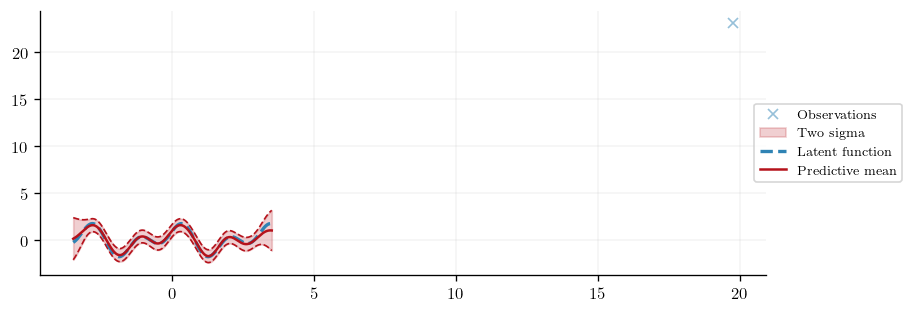

In [73]:
fig, ax = plt.subplots(figsize=(7.5, 2.5))
ax.plot(x, y, "x", label="Observations", color=cols[0], alpha=0.5)
ax.fill_between(
    xtest.squeeze(),
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    label="Two sigma",
    color=cols[1],
)
ax.plot(
    xtest,
    predictive_mean - 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    xtest,
    predictive_mean + 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    xtest, ytest, label="Latent function", color=cols[0], linestyle="--", linewidth=2
)
ax.plot(xtest, predictive_mean, label="Predictive mean", color=cols[1])
ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))
plt.show()

In [76]:
import numpy as np
cov_matrix = latent_dist.covariance()
assert np.allclose(cov_matrix, cov_matrix.T), "Covariance matrix is not symmetric"
eigenvalues = np.linalg.eigvalsh(cov_matrix)
if np.any(eigenvalues <= 0):
    print("Covariance matrix is not positive definite")

In [77]:
np.linalg.cholesky(cov_matrix)

array([[ 1.07154392e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.05219664e+00,  2.41942491e-02,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.03174533e+00,  4.73024239e-02,  2.54635120e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-2.95797035e-07,  7.08337216e-06,  5.28772423e-06, ...,
         1.41720307e-03,  0.00000000e+00,  0.00000000e+00],
       [-4.09376596e-07,  6.95291594e-06,  5.26589602e-06, ...,
         9.85343980e-04,  1.41720307e-03,  0.00000000e+00],
       [-5.19120140e-07,  6.81174664e-06,  5.23391944e-06, ...,
         1.31900946e-03,  9.85343971e-04,  1.41720306e-03]])

In [272]:
print(jax.tree_util.tree_flatten(opt_posterior))

([Array(0.32004336, dtype=float64), Array(0.50186837, dtype=float32), Array(2., dtype=float64)], PyTreeDef(CustomNode(ConjugatePosterior[(['likelihood', 'prior'], [('jitter', 1e-06)])], [CustomNode(Gaussian[(['obs_stddev'], [('integrator', AnalyticalGaussianIntegrator()), ('num_datapoints', 100)])], [*]), CustomNode(Prior[(['kernel', 'mean_function'], [('jitter', 1e-06)])], [CustomNode(RBF2[(['lengthscale', 'variance'], [('_pytree__meta', {'lengthscale': {'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, 'trainable': True, 'name': 'kernel_lengthscale'}, 'variance': {'name': 'kernel_variance', 'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, 'trainable': False, 'pytree_node': True}}), ('active_dims', None), ('compute_engine', DenseKernelComputation()), ('name', 'RBF')])], [*, *]), CustomNode(Zero[([], [('constant', A

In [303]:
def steal_diag_params(diag_params, dataset_coll_train, kernel):
    
    meanf = gpx.mean_functions.Zero()
    art_posterior = initialise_gp(kernel, meanf, dataset_coll_train)
    ravel_func = jax.flatten_util.ravel_pytree(art_posterior)[1]
    
    opt_art_posterior = ravel_func(diag_params)
    
    return opt_art_posterior

In [304]:
jax.tree_util.tree_flatten(opt_posterior)[0]

[Array(0.32004336, dtype=float64),
 Array(0.50186837, dtype=float32),
 Array(2., dtype=float64)]

In [305]:
steal_diag_params(jax.tree_util.tree_flatten(opt_posterior)[0], D, kernel)

TypeError: split requires ndarray or scalar arguments, got <class 'list'> at position 0.

In [274]:
jax.flatten_util.ravel_pytree(opt_posterior)

(Array([0.32004336, 0.50186837, 2.        ], dtype=float64),
 <jax._src.util.HashablePartial at 0x3322ddf50>)

In [243]:
params, tree_structure = jax.tree_util.tree_flatten(opt_posterior)
print("Parameters:", params)
print("Tree Structure:", tree_structure)

Parameters: [Array(0.32004336, dtype=float64), Array(0.50186837, dtype=float32), Array(2., dtype=float64)]
Tree Structure: PyTreeDef(CustomNode(ConjugatePosterior[(['likelihood', 'prior'], [('jitter', 1e-06)])], [CustomNode(Gaussian[(['obs_stddev'], [('integrator', AnalyticalGaussianIntegrator()), ('num_datapoints', 100)])], [*]), CustomNode(Prior[(['kernel', 'mean_function'], [('jitter', 1e-06)])], [CustomNode(RBF2[(['lengthscale', 'variance'], [('_pytree__meta', {'lengthscale': {'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, 'trainable': True, 'name': 'kernel_lengthscale'}, 'variance': {'name': 'kernel_variance', 'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, 'trainable': False, 'pytree_node': True}}), ('active_dims', None), ('compute_engine', DenseKernelComputation()), ('name', 'RBF')])], [*, *]), CustomNode

In [244]:
def print_params(name, param):
    print(f"{name}: {param}")

# Assuming you have some way to associate names with parameters
param_names = ["noise variance", "lengthscale", "variance"]  # Adjust based on actual structure
named_params = dict(zip(param_names, params))

for name, param in named_params.items():
    print_params(name, param)

noise variance: 0.3200433606308615
lengthscale: 0.5018683671951294
variance: 2.0


In [191]:
from gpjax.base import meta_leaves, meta_flatten

meta_leaves(opt_posterior)

[({'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
   'trainable': True,
   'pytree_node': True},
  Array(0.31996357, dtype=float64)),
 ({'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
   'trainable': True,
   'name': 'kernel_lengthscale'},
  Array(0.4553948, dtype=float32)),
 ({'name': 'kernel_variance',
   'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
   'trainable': True,
   'pytree_node': True},
  Array(1.26104189, dtype=float64))]

In [122]:
meta_flatten(opt_posterior)

([({'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
    'trainable': True,
    'pytree_node': True},
   Array(0.31996358, dtype=float64)),
  ({'name': 'kernel_lengthscale',
    'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
    'trainable': True,
    'pytree_node': True},
   Array(0.45539487, dtype=float64)),
  ({'name': 'kernel_variance',
    'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
    'trainable': True,
    'pytree_node': True},
   Array(1.26104246, dtype=float64))],
 PyTreeDef(CustomNode(ConjugatePosterior[(['likelihood', 'prior'], [('jitter', 1e-06)])], [CustomNode(Gaussian[(['obs_stddev'], [('integrator', AnalyticalGaussianIntegrator()), ('num_datapoints', 100)])], [*]), CustomNode(Prior[(['kernel', 'mean_functio

In [ ]:
# In this notebook we demonstate how to fit a Gaussian process regression model.

# %%
# Enable Float64 for more stable matrix inversions.
from jax import config

config.update("jax_enable_x64", True)

from jax import jit
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import install_import_hook
import matplotlib as mpl
import matplotlib.pyplot as plt
import optax as ox
from docs.examples.utils import clean_legend

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx

key = jr.PRNGKey(123)
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

n = 100
noise = 0.3

key, subkey = jr.split(key)
x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(subkey, shape=signal.shape) * noise

D = gpx.Dataset(X=x, y=y)

xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(xtest)

kernel = gpx.kernels.RBF()
meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)

posterior = prior * likelihood

# As outlined in the [PyTrees](https://jax.readthedocs.io/en/latest/pytrees.html)
# documentation, parameters are contained within the model and for the leaves of the
# PyTree. Consequently, in this particular model, we have three parameters: the
# kernel lengthscale, kernel variance and the observation noise variance. Whilst
# we have initialised each of these to 1, we can learn Type 2 MLEs for each of
# these parameters by optimising the marginal log-likelihood (MLL).


negative_mll = gpx.objectives.ConjugateMLL(negative=True)
negative_mll(posterior, train_data=D)

negative_mll = jit(negative_mll)

# We can now define an optimiser. For this example we'll use the `bfgs`
# optimiser.

opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    objective=negative_mll,
    train_data=D,
)


latent_dist = opt_posterior.predict(xtest, train_data=D)
predictive_dist = opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()



In [251]:
kernel = gpx.kernels.RBF()

meta_flatten(kernel)

([({'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
    'trainable': True,
    'pytree_node': True},
   Array(1., dtype=float64, weak_type=True)),
  ({'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
    'trainable': True,
    'pytree_node': True},
   Array(1., dtype=float64, weak_type=True))],
 PyTreeDef(CustomNode(RBF[(['lengthscale', 'variance'], [('active_dims', None), ('compute_engine', DenseKernelComputation()), ('name', 'RBF')])], [*, *])))

In [255]:
shared_l = jnp.array(2, dtype=jnp.float64)

kernel = kernel.replace(lengthscale=shared_l)
meta_flatten(kernel)

([({'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
    'trainable': True,
    'pytree_node': True},
   Array(2., dtype=float64)),
  ({'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
    'trainable': True,
    'pytree_node': True},
   Array(1., dtype=float64, weak_type=True))],
 PyTreeDef(CustomNode(RBF[(['lengthscale', 'variance'], [('active_dims', None), ('compute_engine', DenseKernelComputation()), ('name', 'RBF')])], [*, *])))

In [256]:
opt_posterior.prior.kernel.lengthscale

Array(0.50186837, dtype=float32)

In [257]:
opt_posterior.prior.kernel

RBF2(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array(0.50186837, dtype=float32), variance=Array(2., dtype=float64))

In [ ]:
list_of_dicts = 